## Libraries Import


In [14]:
# !pip install pandas numpy matplotlib

In [15]:
# !pip install requests

In [16]:
import pandas as pd
import requests
import numpy as np
import base64
from datetime import datetime
import matplotlib.pyplot as plt


In [17]:
api_url = 'https://api.company-information.service.gov.uk/company/'
API_KEY = '9d5cad93-47ac-48f1-9adc-9bb206de7d7f'

In [18]:
def get_company_details(company_number):
  response = requests.get(
                f'https://api.company-information.service.gov.uk/company/{company_number}',
                auth=(API_KEY , "")
             )
  return response.json()


def get_company_number(params):
  response = requests.get(
      f'https://api.company-information.service.gov.uk/advanced-search/companies',
      auth=(API_KEY , ""),
      params = params
  )
  return response.json()


def get_company_location(company_number):
  response = requests.get(
      f'https://api.company-information.service.gov.uk/company/{company_number}/registered-office-address',
      auth=(API_KEY , ""),
  )
  return response.json()



In [19]:
def safe_set(df, index, column, value):
    if value not in [None, '', {}, []]:
        df.loc[index, column] = value

## Reading company data

In [20]:
company_data = pd.read_csv('~/Downloads/Company.csv', dtype={'CompanyNumber': str})
#removing extra space from columns
company_data.columns = company_data.columns.str.strip()

In [21]:
company_data.columns

Index(['CompanyName', 'CompanyNumber', 'RegAddress.CareOf', 'RegAddress.POBox',
       'RegAddress.AddressLine1', 'RegAddress.AddressLine2',
       'RegAddress.PostTown', 'RegAddress.County', 'RegAddress.Country',
       'RegAddress.PostCode', 'CompanyCategory', 'CompanyStatus',
       'CountryOfOrigin', 'DissolutionDate', 'IncorporationDate',
       'Accounts.AccountRefDay', 'Accounts.AccountRefMonth',
       'Accounts.NextDueDate', 'Accounts.LastMadeUpDate',
       'Accounts.AccountCategory', 'Returns.NextDueDate',
       'Returns.LastMadeUpDate', 'Mortgages.NumMortCharges',
       'Mortgages.NumMortOutstanding', 'Mortgages.NumMortPartSatisfied',
       'Mortgages.NumMortSatisfied', 'SICCode.SicText_1', 'SICCode.SicText_2',
       'SICCode.SicText_3', 'SICCode.SicText_4',
       'LimitedPartnerships.NumGenPartners',
       'LimitedPartnerships.NumLimPartners', 'URI', 'PreviousName_1.CONDATE',
       'PreviousName_1.CompanyName', 'PreviousName_2.CONDATE',
       'PreviousName_2.Compan

##  Data Profiling

In [22]:
company_data['RegAddress.PostTown'].unique()

array(['BRENTWOOD', 'BASINGSTOKE', nan, 'SURREY', 'SOUTHAMPTON',
       'LOUND LOWESTOFT', 'HYDE', 'BUCKINGHAM', 'DUNMOW', 'LOWESTOFT',
       'United Kingdom', 'hornchurch', 'bilston', 'cosham', 'greenford',
       'melton mowbray', 'newcastle upon tyne', 'bicester',
       'much wenlock', 'southport', 'herne bay', 'leeds', 'thurnscoe',
       'BLACKPOOL', 'NEWCASTLE UPON TYNE', 'ALFRETON', 'RAMSGATE',
       'CHELTENHAM', 'CAMBRIDGE', 'HEREFORD', 'HESKIN', 'WARWICK',
       'GRANGEMOUTH', 'BIRKENSHAW', 'MIDHURST', 'RAYLEIGH',
       'NEWTON-LE-WILLOWS', 'NUNEATON', 'BANBURY', 'MAIDSTONE', 'BOSTON',
       'BRADFORD', 'MUCH WENLOCK', 'ST. HELENS', 'READING', 'SMETHWICK',
       'WIGAN', 'STONEHOUSE', 'HIGH WYCOMBE', 'SOLIHULL', 'LEEDS',
       'MARKET HARBOROUGH', 'YORK', 'KINGS LYNN', 'BRIGHTON', 'HERTFORD',
       'EDINBURGH', 'BINGLEY', 'RUGELEY', 'WATFORD', 'CARMARTHEN',
       'LIVERPOOL', 'NEWTOWNARDS', 'BRANSTON', 'BIRMINGHAM', 'REDHILL',
       'DARTFORD', 'CHADWELL HEATH', 'E

In [23]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CompanyName                         307 non-null    object 
 1   CompanyNumber                       306 non-null    object 
 2   RegAddress.CareOf                   2 non-null      object 
 3   RegAddress.POBox                    5 non-null      object 
 4   RegAddress.AddressLine1             307 non-null    object 
 5   RegAddress.AddressLine2             191 non-null    object 
 6   RegAddress.PostTown                 254 non-null    object 
 7   RegAddress.County                   108 non-null    object 
 8   RegAddress.Country                  248 non-null    object 
 9   RegAddress.PostCode                 304 non-null    object 
 10  CompanyCategory                     306 non-null    object 
 11  CompanyStatus                       306 non-n

In [24]:
company_data['CompanyNumberFromURI'] = company_data['URI'].str.split("/").str[-1]
company_data['CompanyNumber'] = company_data['CompanyNumberFromURI'].fillna(company_data['CompanyNumber'])

In [25]:
 #Finding records which doesn't have CompanyNumber
company_data[company_data['CompanyNumber'].isna()]

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate,CompanyNumberFromURI
11,SURREY,NaN,NaN,KT2 6ER,Private Limited Company,Liquidation,United Kingdom,NaN,05/02/1980,31,...,NaN,19/02/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#Finding companyNumber using postal_code from Company API
postal_code = company_data[company_data['CompanyNumber'].isna()]['RegAddress.POBox']
comapny_details = get_company_number({'location':postal_code})

missing_company_number = comapny_details['top_hit']['company_number']
missing_company_name = comapny_details['top_hit']['company_name']

# company_data.loc[11, 'RegAddress.POBox'] = np.nan
company_data.loc[11, 'CompanyNumber'] = missing_company_number
company_data.loc[11, 'CompanyName'] = missing_company_name
company_data.loc[11, 'RegAddress.POBox'] = np.nan
company_data.loc[11, 'SICCode.SicText_1'] = np.nan


company_data.loc[11]['CompanyNumber']

'01477370'

In [27]:
comapny_details

{'etag': '7de11592821024b8d00713a5c73d799e22bab84b',
 'top_hit': {'company_name': 'BULLDOG PLANTIRE LIMITED',
  'company_number': '01477370',
  'company_status': 'liquidation',
  'company_type': 'ltd',
  'kind': 'search-results#company',
  'links': {'company_profile': '/company/01477370'},
  'date_of_creation': '1980-02-05',
  'registered_office_address': {'address_line_1': '45a Acre Road',
   'address_line_2': 'Kingston-Upon-Thames',
   'locality': 'Surrey',
   'postal_code': 'KT2 6ER'}},
 'items': [{'company_name': 'BULLDOG PLANTIRE LIMITED',
   'company_number': '01477370',
   'company_status': 'liquidation',
   'company_type': 'ltd',
   'kind': 'search-results#company',
   'links': {'company_profile': '/company/01477370'},
   'date_of_creation': '1980-02-05',
   'registered_office_address': {'address_line_1': '45a Acre Road',
    'address_line_2': 'Kingston-Upon-Thames',
    'locality': 'Surrey',
    'postal_code': 'KT2 6ER'}},
  {'company_name': 'MOSAM AUTO SERVICES LTD',
   'comp

In [28]:
company_data['RegAddress.Country'].unique()

array(['UNITED KINGDOM', nan, 'ENGLAND', '05/02/1980', 'england',
       'united kingdom', 'SCOTLAND', 'NORTHERN IRELAND', 'GIBRALTAR',
       'WALES', 'ISLE OF MAN', 'UNITED STATES', 'UK'], dtype=object)

In [29]:
company_data['CountryOfOrigin'].unique()

array(['United Kingdom', nan, '31/05/1986', 'united kingdom', 'GIBRALTAR',
       'ISLE OF MAN', 'UNITED STATES', 'UK'], dtype=object)

In [30]:
company_data['RegAddress.County'].unique()

array([nan, 'HAMPSHIRE', 'SUFFOLK', 'hampshire', 'shropshire', 'kent',
       'rotherham', 'LANCASHIRE', 'KENT', 'GLOUCESTERSHIRE',
       'HEREFORDSHIRE', 'CHORLEY', 'WARWICKSHIRE', 'WEST YORKSHIRE',
       'WEST SUSSEX', 'ESSEX', 'SHROPSHIRE', 'MERSEYSIDE',
       'BUCKINGHAMSHIRE', 'WEST MIDLANDS', 'OXFORDSHIRE',
       'LEICESTERSHIRE', 'NORFOLK', 'STAFFORDSHIRE', 'SURREY', 'DEVON',
       'ISLE OF ANGLESEY', 'NORTHAMPTONSHIRE', 'ENGLAND', 'CAMBS',
       'ISLE OF WIGHT', 'SOMERSET', 'EAST SUSSEX', 'TYNE AND WEAR',
       'HERTFORDSHIRE', 'COUNTY DOWN', 'GWENT', 'NOTTINGHAM',
       'NOTTINGHAMSHIRE', 'OXON', 'VIRGINIA VA20166', 'CHESHIRE',
       'MANCHESTER', 'PETERBOROUGH', ',', 'DYFED', 'NORTH YORKSHIRE',
       '19901', 'LANARKSHIRE'], dtype=object)

In [31]:
company_data['RegAddress.Country'] = company_data['RegAddress.Country'].replace('05/02/1980','')
company_data['RegAddress.County'] = company_data['RegAddress.County'].replace('19901','')
company_data['CountryOfOrigin'] = company_data['CountryOfOrigin'].replace('31/05/1986','')


In [32]:
# Replacing String name from Lower/Upper Case with TitleCase
company_data['RegAddress.Country'] = company_data['RegAddress.Country'].str.title()
company_data['CountryOfOrigin'] = company_data['CountryOfOrigin'].str.title()
company_data['RegAddress.County'] = company_data['RegAddress.County'].str.title()
company_data['RegAddress.PostTown'] = company_data['RegAddress.PostTown'].str.title()
company_data['CompanyName'] = company_data['CompanyName'].str.title()


company_data['RegAddress.Country'] = company_data['RegAddress.Country'].replace('Uk', 'United Kingdom')
company_data['CountryOfOrigin'] = company_data['CountryOfOrigin'].replace('Uk', 'United Kingdom')

In [33]:

company_data['Accounts.AccountCategory'].unique()

array(['NO ACCOUNTS FILED', 'TOTAL EXEMPTION FULL', 'MICRO ENTITY',
       'DORMANT', nan, '0', 'total exemption full', 'no accounts filed',
       'micro entity', 'small', 'dormant', 'full', 'SMALL',
       'UNAUDITED ABRIDGED', 'FULL', 'TOTAL EXEMPTION SMALL',
       'AUDIT EXEMPTION SUBSIDIARY', 'ACCOUNTS TYPE NOT AVAILABLE',
       'GROUP', '10/06/3017'], dtype=object)

In [34]:
company_data['Accounts.AccountCategory'] = company_data['Accounts.AccountCategory'].replace('TOTAL EXEMPTION FULL','TOTAL-EXEMPTION-FULL')

## Data Validation & Matching

In [35]:
for index,company_number in enumerate(company_data.loc[:,'CompanyNumber']):
  details = get_company_details(company_number)
  if not details.get('message'):
    # Mark record found
      company_data.loc[index, 'record_found'] = True

      addr = details.get('registered_office_address', {})
      accounts = details.get('accounts', {})
      last_accounts = accounts.get('last_accounts', {})
      conf_stmt = details.get('confirmation_statement', {})
      next_accounts = accounts.get('next_accounts', {})
      links = details.get('links', {})

      safe_set(company_data, index, 'RegAddress.AddressLine1', addr.get('address_line_1'))
      safe_set(company_data, index, 'RegAddress.AddressLine2', addr.get('address_line_2'))
      safe_set(company_data, index, 'RegAddress.PostTown', addr.get('locality'))
      safe_set(company_data, index, 'CompanyStatus', details.get('company_status', '').title())
      safe_set(company_data, index, 'Accounts.AccountCategory',
              last_accounts.get('type', 'NO ACCOUNTS FILED').upper() if last_accounts else 'NO ACCOUNTS FILED')
      safe_set(company_data, index, 'RegAddress.County', addr.get('region'))

      # Only update CompanyCategory if type is 'ltd'
      if details.get('type') == 'ltd':
          company_data.loc[index, 'CompanyCategory'] = 'Private Limited Company'

      safe_set(company_data, index, 'RegAddress.PostCode', addr.get('postal_code'))
      safe_set(company_data, index, 'CountryOfOrigin', addr.get('country'))
      safe_set(company_data, index, 'RegAddress.Country', addr.get('country'))
      safe_set(company_data, index, 'IncorporationDate', next_accounts.get('period_start_on'))
      safe_set(company_data, index, 'Accounts.AccountRefDay', accounts.get('accounting_reference_date', {}).get('day'))
      safe_set(company_data, index, 'Accounts.AccountRefMonth', accounts.get('accounting_reference_date', {}).get('month'))
      safe_set(company_data, index, 'Accounts.NextDueDate', next_accounts.get('due_on'))
      safe_set(company_data, index, 'Accounts.LastMadeUpDate', last_accounts.get('made_up_to'))
      safe_set(company_data, index, 'ConfStmtNextDueDate', conf_stmt.get('next_due'))
      safe_set(company_data, index, 'ConfStmtLastMadeUpDate', conf_stmt.get('last_made_up_to'))

      # Check if ConfStmtLastMadeUpDate is still null then setConfStmtIsfDue is set as true
      company_data.loc[index, 'ConfStmtIsfDue'] = pd.isna(company_data.loc[index, 'ConfStmtLastMadeUpDate'])

      # Build the URI
      self_link = links.get('self')
      if self_link:
          company_data.loc[index, 'URI'] = f"http://business.data.gov.uk/id/{self_link}"

      # For previous_company_names
      previous_names = details.get('previous_company_names', [])
      if previous_names and isinstance(previous_names, list):
          for i,obj in enumerate(previous_names):
            company_data.loc[index, f'PreviousName_{i+1}.CONDATE'] = previous_names[i].get('ceased_on')
            company_data.loc[index, f'PreviousName_{i+1}.CompanyName'] = previous_names[i].get('name')

  else:
    print(f"{company_number} record not found")
    company_data.loc[index,'record_found'] = False

C:\Users\pbsha\AppData\Local\Temp\ipykernel_16096\1745839943.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '31' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, column] = value
C:\Users\pbsha\AppData\Local\Temp\ipykernel_16096\1027174707.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1989-04-14' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  company_data.loc[index, f'PreviousName_{i+1}.CONDATE'] = previous_names[i].get('ceased_on')
C:\Users\pbsha\AppData\Local\Temp\ipykernel_16096\1027174707.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'R.G.CARTER (DEVELOPMENTS) LIMITED' has dtype incompatible with float64, please explicitly 

05883574 record not found


## Formatting Date Records

In [36]:
def convert_column_datatype(column_name):
  company_data[column_name] = pd.to_numeric(
      company_data[column_name],
      downcast='integer',
      errors='coerce'
  )

def date_formatting(columnName):
  date1 = pd.to_datetime(company_data[columnName], errors='coerce', format='%d/%m/%Y')
  date2 = pd.to_datetime(company_data[columnName], errors='coerce', format='%Y-%m-%d')
  date3 = pd.to_datetime(company_data[columnName], errors='coerce', format='%d%m%Y')
  company_data[columnName] = date1.fillna(date2).fillna(date3)

In [37]:
# Formating Date fields to date type
date_columns = ['PreviousName_1.CONDATE','PreviousName_2.CONDATE',
                'PreviousName_3.CONDATE',
                'PreviousName_4.CONDATE',
                'PreviousName_5.CONDATE',
                'PreviousName_6.CONDATE',
                'PreviousName_7.CONDATE',
                'PreviousName_8.CONDATE',
                'PreviousName_9.CONDATE', 'PreviousName_10.CONDATE',
                'ConfStmtNextDueDate','ConfStmtLastMadeUpDate',
                'DissolutionDate','IncorporationDate','Accounts.NextDueDate', 'Accounts.LastMadeUpDate', 'Returns.NextDueDate','Returns.LastMadeUpDate']
for column in date_columns:
  date_formatting(column)

column_data_type = {column:'datetime64[ns]' if 'date' in column.lower() else 'string' for column in company_data.columns}
column_data_type['ConfStmtIsfDue'] = 'bool'
column_data_type['record_found'] = 'bool'
company_data = company_data.astype(column_data_type)


In [38]:
company_data['ConfStmtIsfDue'].fillna('True')

0       True
1      False
2      False
3      False
4      False
       ...  
302    False
303    False
304     True
305     True
306    False
Name: ConfStmtIsfDue, Length: 307, dtype: bool

In [39]:
convert_column_datatype('Accounts.AccountRefMonth')
convert_column_datatype('Accounts.AccountRefDay')
convert_column_datatype('Mortgages.NumMortOutstanding')
convert_column_datatype('Mortgages.NumMortCharges')
convert_column_datatype('Mortgages.NumMortPartSatisfied')
convert_column_datatype('Mortgages.NumMortSatisfied')
convert_column_datatype('LimitedPartnerships.NumLimPartners')


In [40]:
#checking Datatype of columns
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 58 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   CompanyName                         307 non-null    string        
 1   CompanyNumber                       307 non-null    string        
 2   RegAddress.CareOf                   2 non-null      string        
 3   RegAddress.POBox                    4 non-null      string        
 4   RegAddress.AddressLine1             307 non-null    string        
 5   RegAddress.AddressLine2             196 non-null    string        
 6   RegAddress.PostTown                 305 non-null    string        
 7   RegAddress.County                   111 non-null    string        
 8   RegAddress.Country                  252 non-null    string        
 9   RegAddress.PostCode                 305 non-null    string        
 10  CompanyCategory           

## Finding and Handling Duplicates

In [41]:
company_records = company_data.groupby('CompanyNumber').agg({'CompanyNumber':'count'}).rename(columns={'CompanyNumber':'duplicates'})
company_records[company_records['duplicates']>1]

,duplicates
CompanyNumber,
01477370,2
04466066,2
05057638,2
05717974,2
06590854,2
08403564,2
09084985,2
10141677,2
10399598,2


In [42]:
# removing duplicate rows which has highest Null Values
company_data['non_null_count'] = company_data.notna().sum(axis=1)
company_data = company_data.sort_values(by=['CompanyNumber', 'non_null_count'], ascending=[True, False])
company_data = company_data.drop_duplicates(subset='CompanyNumber', keep='first').reset_index(drop=True)

#### Following record was not found in Company Data API

In [43]:
company_data[company_data['record_found']==False]

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate,CompanyNumberFromURI,record_found,ConfStmtIsfDue,non_null_count
46,Airline 4 Dialogue Ltd,05883574,<NA>,<NA>,6 NORTH STREET,<NA>,Oundle,Peterborough,England,PE8 4AL,...,NaT,<NA>,NaT,<NA>,NaT,NaT,05883574,False,True,25


## Data Reporting & visualisation

### Number of Records per each Account Category




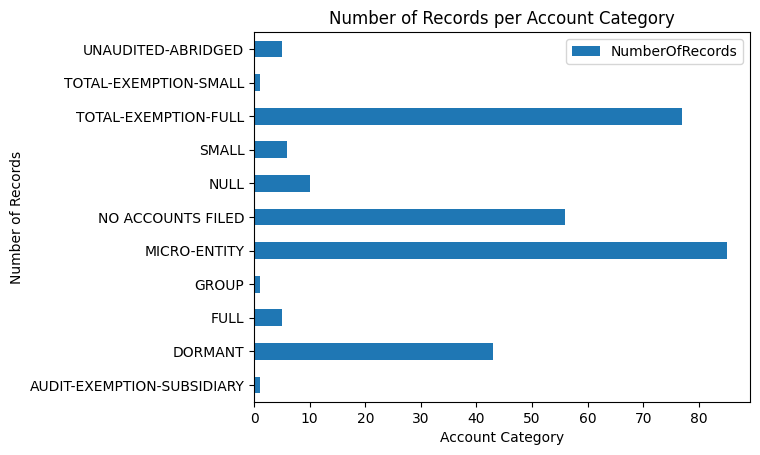

In [44]:
category_counts = company_data.groupby('Accounts.AccountCategory').agg({'Accounts.AccountCategory':'count'}).rename(columns= {'Accounts.AccountCategory':'NumberOfRecords'})
category_counts.plot(kind='barh')
plt.title('Number of Records per Account Category')
plt.xlabel('Account Category')
plt.ylabel('Number of Records')

plt.show()


#### Finding number of records avaialble for each country

In [45]:

country_wise_company = company_data.groupby(['RegAddress.Country'])['CompanyNumber'].count().reset_index()
country_wise_company[:]

,RegAddress.Country,CompanyNumber
0,,1
1,England,147
2,Gibraltar,1
3,Isle Of Man,1
4,Northern Ireland,1
5,Scotland,8
6,United Kingdom,78
7,United States,1
8,Wales,1


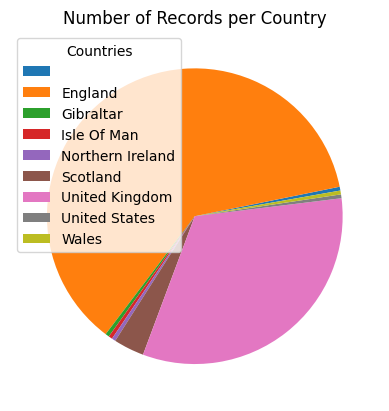

In [46]:

wedges, texts = plt.pie(
    country_wise_company['CompanyNumber'],
    startangle=10
)
plt.title('Number of Records per Country')

plt.legend(wedges, country_wise_company['RegAddress.Country'], title="Countries", loc="upper left")
plt.show()

#### Number of Records per Country and Account Category

In [47]:

company_data.groupby(['RegAddress.Country','Accounts.AccountCategory'])['Accounts.AccountCategory'].count()

RegAddress.Country  Accounts.AccountCategory  
                    TOTAL-EXEMPTION-FULL           1
England             DORMANT                       22
                    FULL                           3
                    MICRO-ENTITY                  49
                    NO ACCOUNTS FILED             30
                    NULL                           5
                    SMALL                          3
                    TOTAL-EXEMPTION-FULL          34
                    TOTAL-EXEMPTION-SMALL          1
Gibraltar           NO ACCOUNTS FILED              1
Isle Of Man         NO ACCOUNTS FILED              1
Northern Ireland    DORMANT                        1
Scotland            NO ACCOUNTS FILED              1
                    NULL                           1
                    TOTAL-EXEMPTION-FULL           4
                    UNAUDITED-ABRIDGED             2
United Kingdom      AUDIT-EXEMPTION-SUBSIDIARY     1
                    DORMANT                       12

#### Finding out how many companies in each country has Partially Paid Mortgage, Outstanding Mortgage and Paid Mortgage.


In [48]:

company_status_mortgage = company_data.groupby(['RegAddress.Country','CompanyStatus']).\
            agg({'CompanyNumber':'count',
                'Mortgages.NumMortOutstanding':'sum',
                'Mortgages.NumMortPartSatisfied':'sum',
                'Mortgages.NumMortSatisfied':'sum'})\
          .rename(columns={
          'CompanyNumber': 'CompanyCount',
          'Mortgages.NumMortOutstanding': 'OutstandingMortgage',
          'Mortgages.NumMortPartSatisfied': 'PartSatisfiedMortgage',
          'Mortgages.NumMortSatisfied': 'SatisfiedMortgage(Paid Mortgages)'
      })

In [49]:
company_status_mortgage

CompanyCount  OutstandingMortgage  \
RegAddress.Country CompanyStatus                                      
                   Liquidation               1                    0   
England            Active                  124                   48   
                   Dissolved                21                   11   
                   Liquidation               2                    1   
Gibraltar          Registered                1                    0   
Isle Of Man        Registered                1                    0   
Northern Ireland   Active                    1                    0   
Scotland           Active                    8                    1   
United Kingdom     Active                   65                   21   
                   Dissolved                13                    0   
United States      Active                    1                    0   
Wales              Active                    1                    0   

                                  PartSatisfiedMortgage  \
RegAddress.Country CompanyStatus                          
                   Liquidation                        0   
England            Active                             0   
                   Dissolved                          0   
                   Liquidation                        0   
Gibraltar          Registered                         0   
Isle Of Man        Registered                         0   
Northern Ireland   Active                             0   
Scotland           Active                             0   
United Kingdom     Active                             0   
                   Dissolved                          0   
United States      Active                             0   
Wales              Active                             0   

                                  SatisfiedMortgage(Paid Mortgages)  
RegAddress.Country CompanyStatus                                     
                   Liquidation                                    0  
England            Active                                        25  
                   Dissolved                                     37  
                   Liquidation                                    0  
Gibraltar          Registered                                     0  
Isle Of Man        Registered                                     0  
Northern Ireland   Active                                         0  
Scotland           Active                                         0  
United Kingdom     Active                                        15  
                   Dissolved                                      0  
United States      Active                                         0  
Wales              Active                                         0

#### Finding how many companies has confirmation_statement overdue

In [50]:

company_data.groupby(['ConfStmtIsfDue'])['ConfStmtIsfDue'].count()

ConfStmtIsfDue
False    251
True      39
Name: ConfStmtIsfDue, dtype: int64

In [51]:
company_data.to_csv('company_data_cleaned.csv')